In [2]:
!pip install onnxruntime
!pip install onnx
!pip install openvino
!pip install --upgrade openvino-dev
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms.functional as F
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import time
import onnxruntime
import onnx
import openvino as ov
from openvino.tools import mo
import tensorflow as tf
import torchvision.models as models
import random
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.3 MB/s eta 0:00:00
  Created wheel for jstyleson: filename=jstyleson-0.0.2-py3-none-any.whl size=2385 sha256=69bde8a6ae9bcc835f8df4845985261d28e24871afdec6f0dd9f179f641b90ca
  Stored in directory: /root/.cache/pip/wheels/12/51/c6/a1e751db88203e11c6d9ffe4683ca3d8c14b1479639bec1006
Successfully built jstyleson
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
cifar100_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
cifar100_test = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
bicycle_id = cifar100_train.classes.index('motorcycle')
motorcycle_id = cifar100_train.classes.index('bicycle')

100%|██████████| 169001437/169001437 [00:01<00:00, 98333496.78it/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
def get_new_targets(old_targets):
    return [0 if t == bicycle_id else 1 if t == motorcycle_id else 2 for t in old_targets]
def get_new_data_shape(data):
    return torch.tensor(np.transpose(data, (0, 3, 1, 2)))

In [5]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label

In [6]:
def get_balanced_subset(data, targets, num_samples_per_category=500):
    category_indices = {}
    for i, target in enumerate(targets):
        if target not in category_indices:
            category_indices[target] = []
        category_indices[target].append(i)

    balanced_indices = []
    for category, indices in category_indices.items():
        balanced_indices.extend(random.sample(indices, min(num_samples_per_category, len(indices))))

    subset_data = [data[i] for i in balanced_indices]
    subset_targets = [targets[i] for i in balanced_indices]

    return subset_data, subset_targets

subset_data_train, subset_targets_train = get_balanced_subset(cifar100_train.data, get_new_targets(cifar100_train.targets), num_samples_per_category=500)
dataset_train = CustomDataset(get_new_data_shape(subset_data_train), subset_targets_train)

subset_data_test, subset_targets_test = get_balanced_subset(cifar100_test.data, get_new_targets(cifar100_test.targets), num_samples_per_category=100)
dataset_test = CustomDataset(get_new_data_shape(subset_data_test), subset_targets_test)

In [7]:
model = models.resnet18(pretrained=True)
device = torch.device('cuda')
model = model.to(device)

batch_size = 64
epochs = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 92.5MB/s]


In [8]:
def train(model, train_loader, criterion, optimizer, device, epochs):
    res_loss = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        res_loss.append(running_loss)
    return res_loss

def predict(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
      for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs.float())
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

In [9]:
total_loss = train(model, train_loader, criterion, optimizer, device, epochs)
all_preds_original, all_labels_original = predict(model, test_loader, device)

**<h1>Pretrained ResNet18**

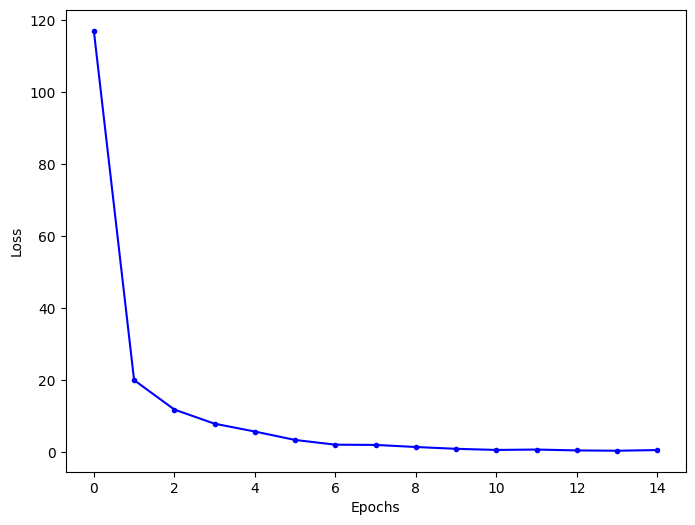

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(total_loss, marker='.', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

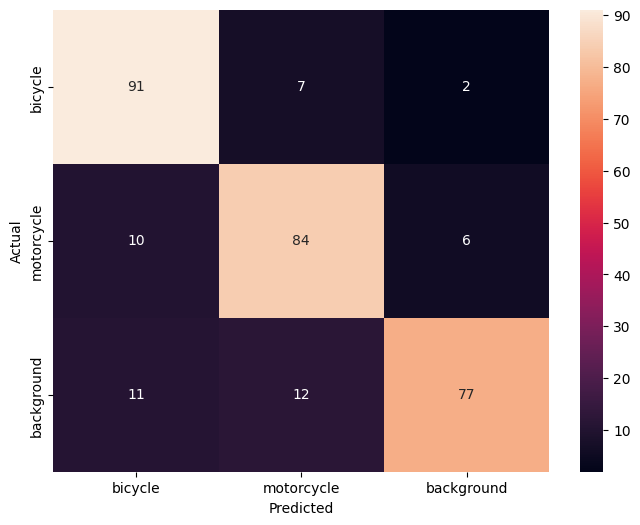

In [21]:
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(all_labels_original, all_preds_original)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['bicycle', 'motorcycle', 'background'], yticklabels=['bicycle', 'motorcycle', 'background'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**<h1>Comparison PyTorch CPU, PyTorch GPU, ONNX, OpenVino**

In [12]:
results = {}
epochs_ = 100
input = dataset_test[0][0]
input = input.float().unsqueeze(0)

**<h1>PyTorch, CPU**

In [13]:
model.to(torch.device("cpu"))
input = input.to(torch.device("cpu"))
time_start = time.time()
for epoch in range(100):
  with torch.no_grad():
    model(input)
time_end = time.time()
results["CPU, PyTorch"] = (time_end - time_start)

**<h1>PyTorch, GPU**

In [14]:
model.to(torch.device("cuda"))
input = input.to(torch.device("cuda"))
time_start = time.time()
for epoch in range(100):
  with torch.no_grad():
    model(input)
time_end = time.time()
results["GPU, PyTorch"] = (time_end - time_start)

**<h1>ONNX**

In [15]:
model.to(torch.device("cpu"))
input = input.to(torch.device("cpu"))
torch.onnx.export(model, input, "model.onnx")
ort_session = onnxruntime.InferenceSession("model.onnx")
time_start = time.time()
for epoch in range(100):
  with torch.no_grad():
    ort_session.run(None, {"input.1": np.array(input)})
time_end = time.time()
results["ONNX"] = (time_end - time_start)

**<h1>OpenVino**

In [16]:
core = ov.Core()
model.to(torch.device("cpu"))
model_ov = ov.tools.mo.convert_model(model, example_input=input)
model_ov = core.compile_model(model=model_ov, device_name="CPU")
input_layer = model_ov.input(0)
output_layer = model_ov.output(0)
time_start = time.time()
for epoch in range(100):
  with torch.no_grad():
    model_ov(input)[output_layer]
time_end = time.time()
results["OpenVino"] = (time_end - time_start)

**<h1>Comparison results**

Text(0, 0.5, 'Time,s')

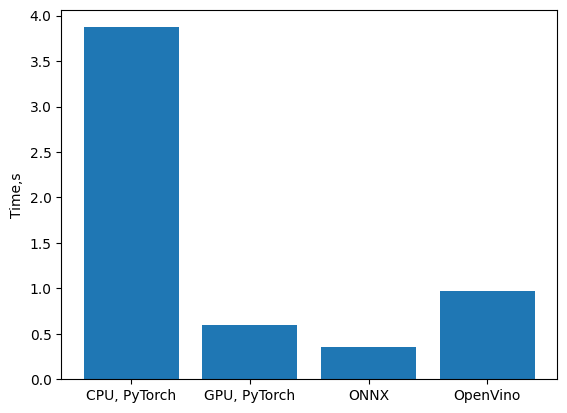

In [17]:
plt.bar(results.keys(), results.values())
plt.ylabel('Time,s')

**<h1>Transform to grayscale**

In [18]:
class ToGrayscale(object):
    def __call__(self, img):
        return transforms.functional.rgb_to_grayscale(img)
transform_gray = transforms.Compose([
    ToGrayscale(),
    transforms.ToTensor()
])

train_loader.dataset.transform = transform_gray
test_loader.dataset.transform = transform_gray

In [19]:
model_gray = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_gray.fc.in_features
model_gray.fc = nn.Linear(num_ftrs, 3)
model_gray = model_gray.to(device)
optimizer_gray = optim.SGD(model_gray.parameters(), lr=0.001, momentum=0.9)
criterion_gray = nn.CrossEntropyLoss()
total_loss_gray = train(model_gray, train_loader, criterion_gray, optimizer_gray, device, epochs)
all_preds_gray, all_labels_gray = predict(model_gray, test_loader, device)

**<h1>Pretrained ResNet 18, GrayScale**

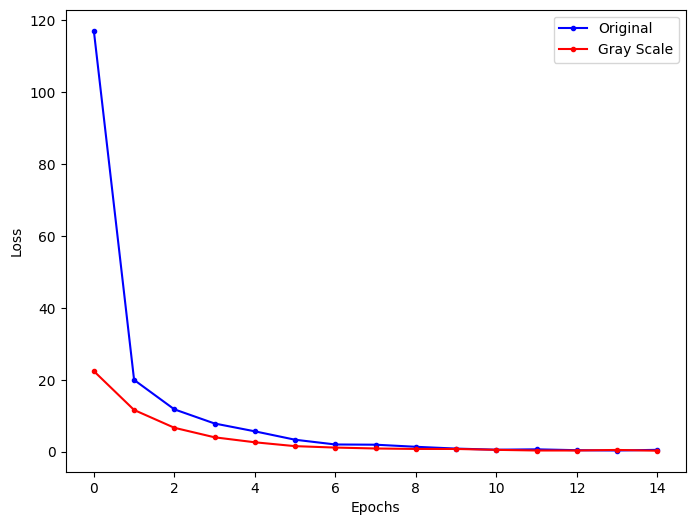

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(total_loss, marker='.', color='b')
plt.plot(total_loss_gray, marker='.', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Original', 'Gray Scale'])
plt.show()

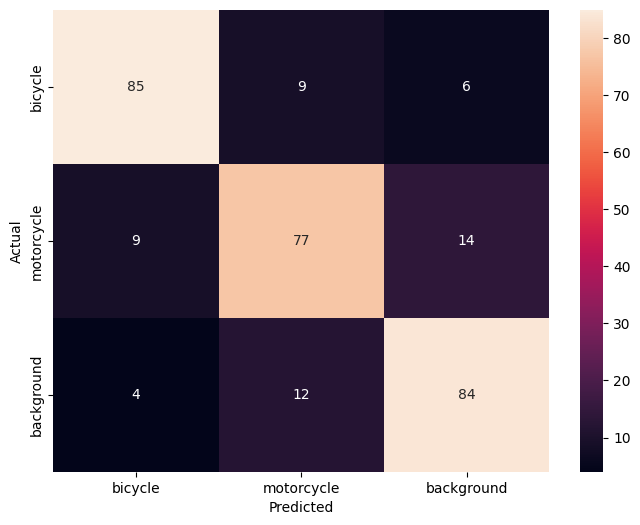

In [22]:
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(all_labels_gray, all_preds_gray)
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=['bicycle', 'motorcycle', 'background'], yticklabels=['bicycle', 'motorcycle', 'background'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()